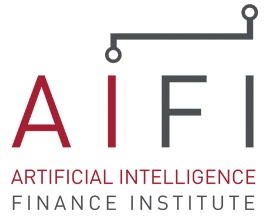


# Bootcamp - Python and Coding - Supervised Machine Learning

# Machine Learning with scikit-learn – Regression  

# About this notebook

For this notebook,  we use regression models to predict the yield curve. This notebook is inspired by the paper [“Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting”](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3144622) by Nunes, Gerding, McGroarty and Niranj. 


In the supervised regression framework used for this notebook, three [tenors](https://www.investopedia.com/terms/t/tenor.asp) (i.e. 1M, 5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short term, medium term and long-term tenors of the yield curve. The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict.

<br>

Tenor is the length of time remaining before a financial contract expires.<br>
A yield curve is a representation of the relationship between market remuneration rates and the remaining time to maturity of debt securities.

We will have a sneak peak at an ANN and compare it with a simple regression. For the case seen here in the notebook, the regression performs better, but we need to keep in mind, that a Multi Layer Perceptron (MLP) is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM, which we will visit on the next day.

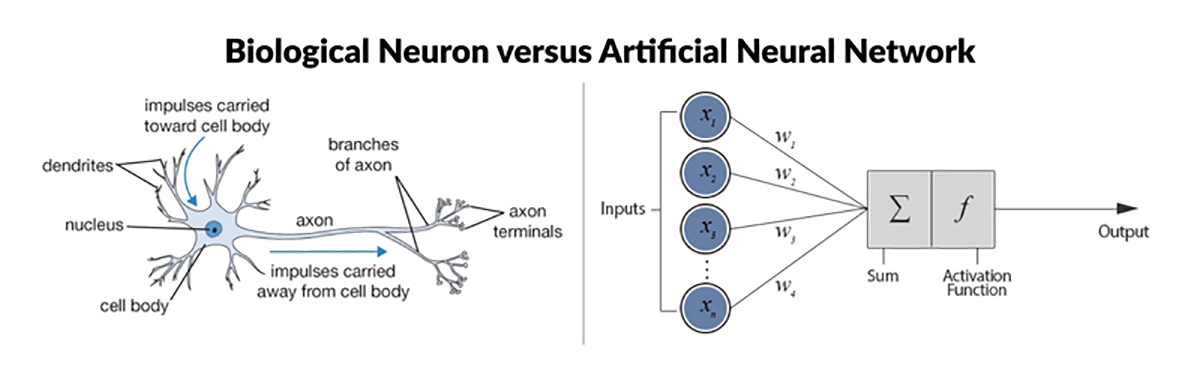

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 
       3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import sys
import os

# import for scraping
import pandas_datareader.data as web


# imports for plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import scatter_matrix
import seaborn as sns
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

# sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Libraries for Deep Learning Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


#Libraries for Statistical Models
from statsmodels.tsa.seasonal import seasonal_decompose

# Time series Models
from statsmodels.tsa.arima_model import ARIMA

#Libraries for Saving the Model
from pickle import dump
from pickle import load


#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')


# custom library
py_file_location = '../../'
sys.path.append(os.path.abspath(py_file_location))
from customlib import technical_analysis as ta
from customlib import plotting as pl

In [2]:
# custom styled plotting settings
%matplotlib inline
#sns.set_style('whitegrid', {'axes.facecolor': '.95'})
plt.style.use('../../custom_plot_style.mplstyle') # use the custom style sheet

# use custom styed font and image settings 
mpl.rcParams['font.family'] = 'sans-serif' 
mpl.rcParams['font.sans-serif'] = ['Tahoma']
%config InlineBackend.figure_format = 'svg'

## Loading the Data

We get the data by webscapping using [pandas datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html), which extracts data from various Internet sources into a pandas DataFrame. In this case, we use `Federal Reserve Economic Data (FRED)` as the data source. With the datareader you can also use data sources such as `Quandl` or `World Bank’s World Development Indicators` and more, see [documentation](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#world-bank) for a full overview. 

In [3]:
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               # U.S. Treasury securities held by the Federal Reserve (Millions of Dollars)
               'TREAST',
               # Federal Debt Held by the Public (Millions of Dollars)
               'FYGFDPUN',
               # Federal Debt Held by Foreign and International Investors (Billions of Dollars)
               'FDHBFIN',
               # Federal Debt: Total Public Debt (Millions of Dollars)
               'GFDEBTN',
               'BAA10Y',  # Baa Corporate Bond Yield Relative to Yield on 10-Year
               ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 5

Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5',
                     'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [5]:
dataset.head(2)

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2019-04-01,2.43,2.33,2.93,2.42,2.43,2.41,2.33,2.31,2.40,2.49,2.89,0.098786,0.735799,0.300859,2.24
2019-04-08,2.42,2.37,2.96,2.43,2.43,2.43,2.36,2.33,2.42,2.52,2.93,0.097774,0.735799,0.300859,2.21


#  EDA

## Descriptive Statistics

In [6]:
dataset.shape

(244, 15)

In [7]:
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,1.904180,2.094672,2.690574,1.891598,2.010082,2.101107,2.052090,2.088566,2.206885,2.282910,2.685615,0.155334,0.775381,0.258229,2.170779
std,2.049308,1.454137,1.003723,2.036587,2.089112,2.004744,1.788784,1.450069,1.328942,1.215969,0.999711,0.032647,0.018915,0.024997,0.404786
min,0.000000,0.220000,1.220000,0.000000,0.010000,0.040000,0.110000,0.220000,0.390000,0.550000,1.220000,0.091250,0.735799,0.227128,1.580000
25%,0.080000,0.805000,1.920000,0.080000,0.090000,0.130000,0.210000,0.805000,1.155000,1.380000,1.920000,0.145781,0.776077,0.235300,1.910000
50%,1.535000,1.675000,2.340000,1.535000,1.560000,1.590000,1.620000,1.675000,1.775000,1.865000,2.340000,0.163814,0.782259,0.254820,2.110000
75%,3.727500,3.632500,3.670000,3.675000,4.280000,4.600000,4.125000,3.622500,3.570000,3.520000,3.662500,0.183074,0.786267,0.266346,2.270000
max,5.690000,4.860000,5.090000,5.690000,5.620000,5.460000,5.120000,4.860000,4.930000,4.930000,5.090000,0.190761,0.794441,0.304740,4.230000


## Data Visualization

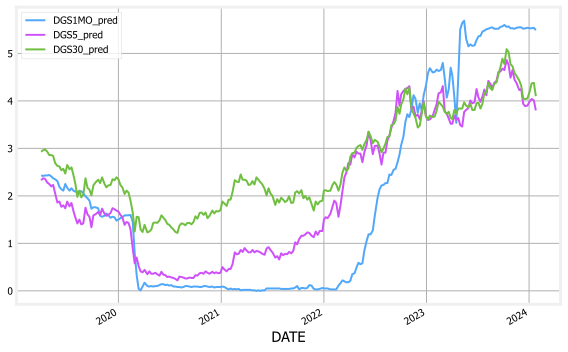

In [8]:
Y.plot();

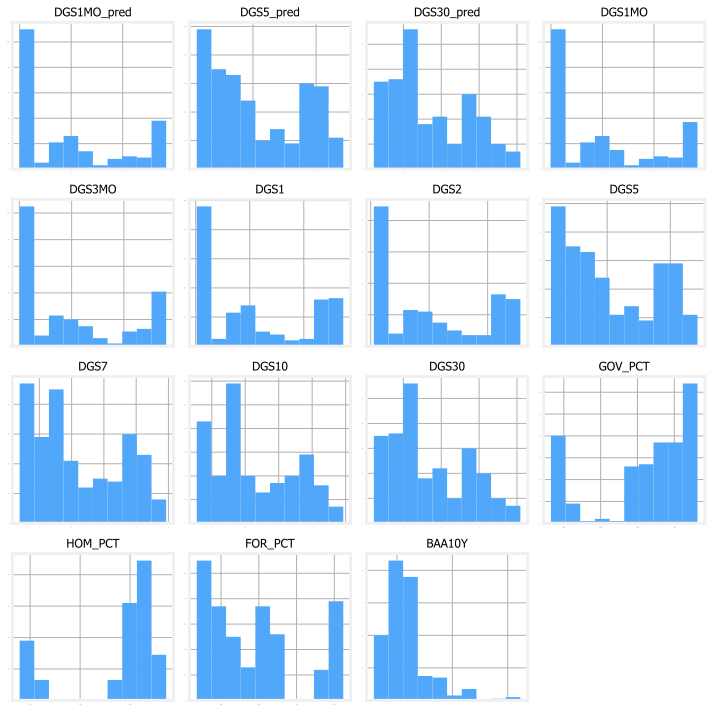

In [9]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1,
             ylabelsize=1, figsize=(10, 10));

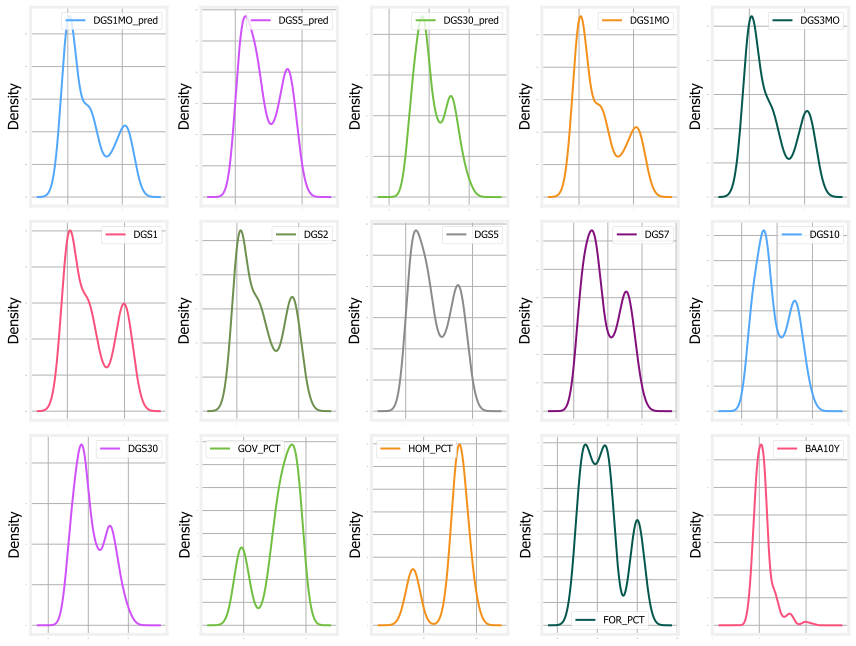

In [10]:
# density
dataset.plot(kind='density', subplots=True, layout=(4, 5),
             sharex=False, legend=True, fontsize=1, figsize=(12, 12));

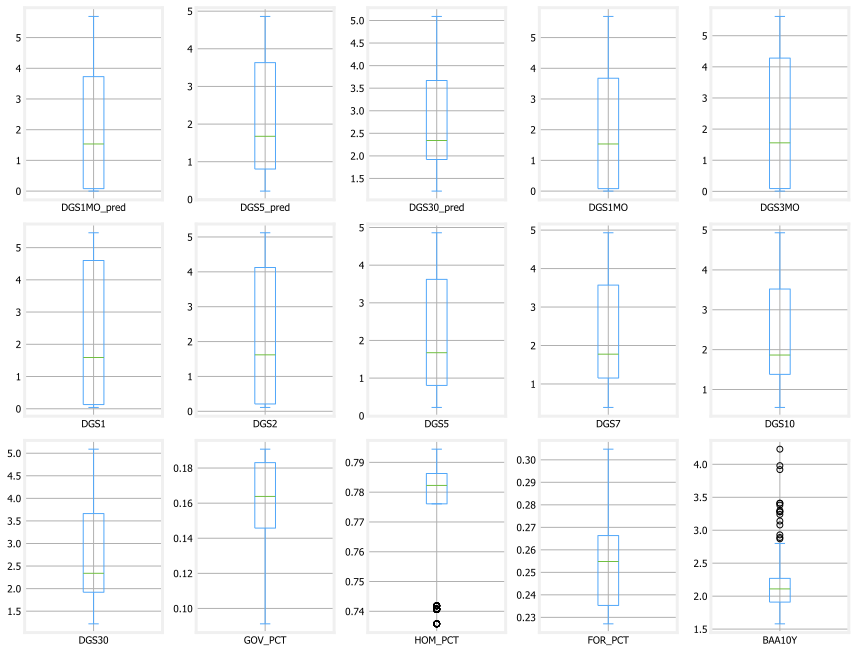

In [11]:
# Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(4, 5),
             sharex=False, sharey=False, figsize=(12, 12));

Next We look at the interaction between these variables.

<Axes: title={'center': 'Correlation Matrix'}>

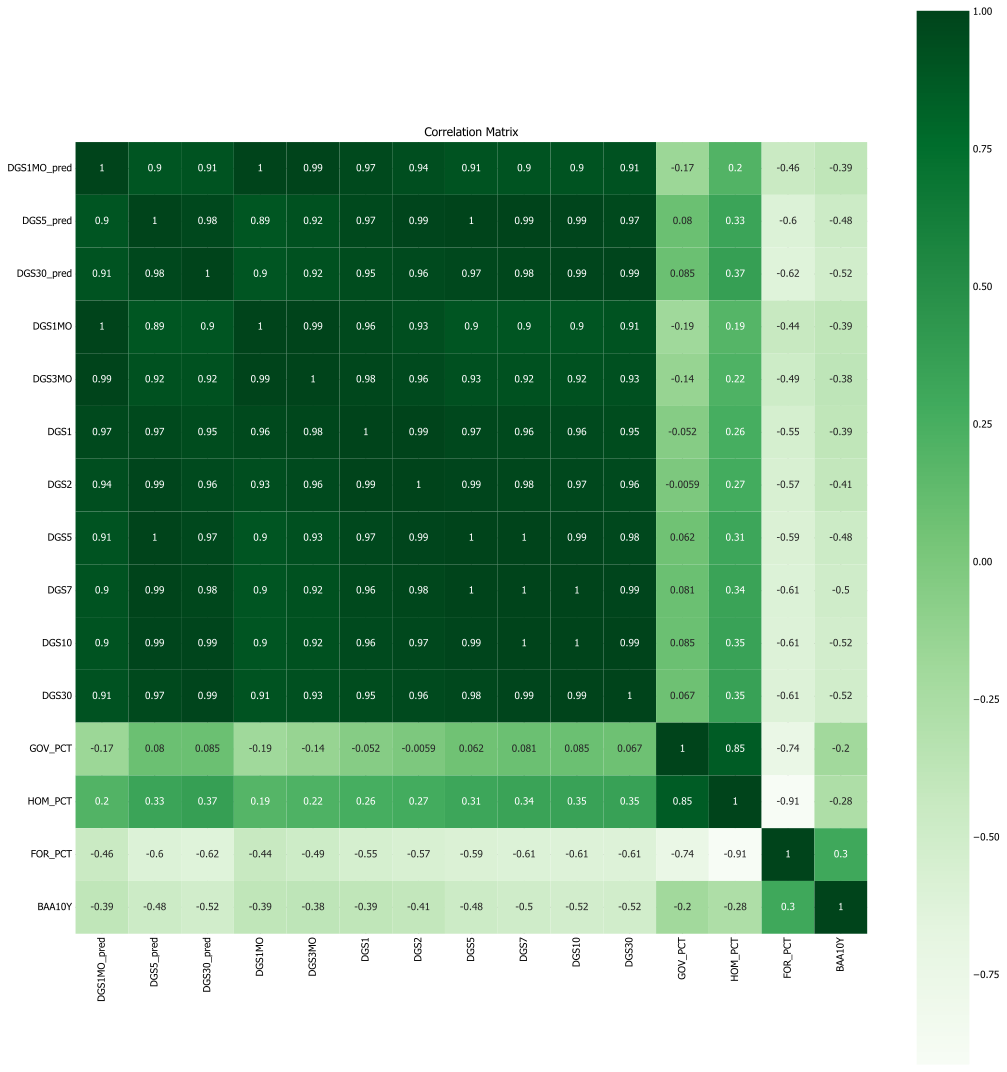

In [12]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='Greens')

From the correlation plot, we see that the 5 year yield seems to be negativly correlated with the changes in foreign goverment purchases.

In [13]:
# Scatterplot Matrix
plt.figure(figsize=(15, 15))
scatter_matrix(dataset, figsize=(15, 16));

<Figure size 4500x4500 with 0 Axes>

## Data Preparation and Analysis

## Feature Selection

### SelectKBest
 
 
SelectKBest is a widely utilized method for feature selection in the field of machine learning. It's benefits are: 

- In filter-based feature selection methods, the feature selection process is done independently of any specific machine learning algorithm. Instead, it relies on statistical measures to score and rank the features.

- SelectKBest uses various statistical tests, such as the chi-squared test, ANOVA F-test, or mutual information score, to evaluate and rank features according to their relevance to the target variable. It then selects the top K features with the highest scores for the final set of features.

- Due to its simplicity and effectiveness, SelectKBest is particularly beneficial for reducing the dimensionality of large datasets, making it a usful tool for streamlining the feature set to a more manageable size.

In [ ]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X, temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    # concat two dataframes for better visualization
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10, 'Score'))  # print 10 best features
    print('--------------')
    # As expected, based on the univariate feature selection, all the time series are 
    # most dependent on the previous changes.

# Evaluate Algorithms and Models

## Train Test Split and evaluation metrics

In [ ]:
# split out validation dataset for the end

validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed)

We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data.

In [ ]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

## Compare Models and Algorithms

In [ ]:
# initialize the models
models = []

models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge(alpha=.5)))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))

# NN
models.append(('MLP', MLPRegressor()))

In [ ]:
tscv_results = []
names = []
validation_results = []
train_results = []

In [19]:
for name, model in models:
    tscv = TimeSeriesSplit(n_splits=num_folds)
    # converted mean square error to positive. The lower the better
    cv_results = -1 * \
        cross_val_score(model, X_train, Y_train, cv=tscv, scoring=scoring)
    tscv_results.append(cv_results)
    names.append(name)
    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(
        np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)

    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
        (name, str(cv_results.mean()), str(cv_results.std()),
         str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.031462204686340645 
Std CV Error: (0.021682577031154816) 
Training Error:
0.016408527265079655 
Test Error:
0.013954364083447059
----------
Ridge: 
Average CV error: 0.02063556534916667 
Std CV Error: (0.00775024872080379) 
Training Error:
0.01704784903786024 
Test Error:
0.01501707718408836
----------
LASSO: 
Average CV error: 0.3429208791182398 
Std CV Error: (0.05139529543225776) 
Training Error:
0.3312916254726664 
Test Error:
0.3331067098935161
----------
EN: 
Average CV error: 0.1858319873571931 
Std CV Error: (0.02432021936096737) 
Training Error:
0.17481646469613454 
Test Error:
0.18064454671981584
----------
MLP: 
Average CV error: 0.10417554208025208 
Std CV Error: (0.12416852187343898) 
Training Error:
0.021815612429756118 
Test Error:
0.020834256633808217
----------


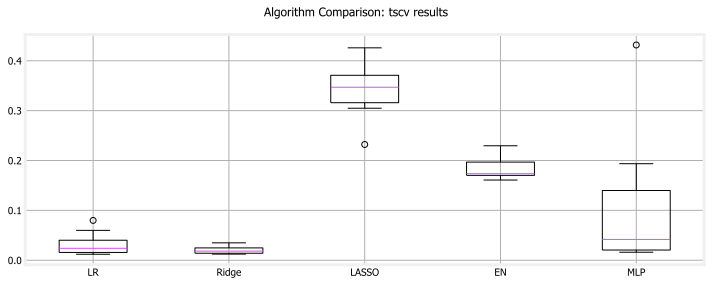

In [20]:
# compare algorithms
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison: tscv results')
ax = fig.add_subplot(111)
plt.boxplot(tscv_results)
ax.set_xticklabels(names)
fig.set_size_inches(10, 4);

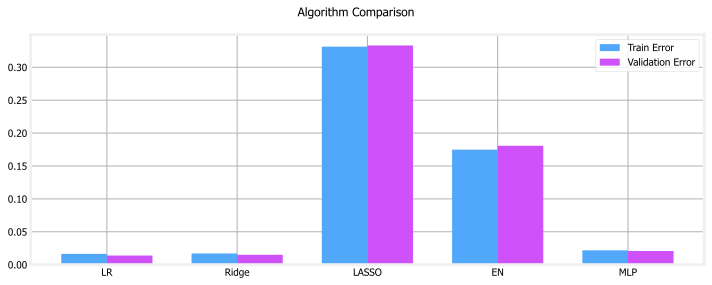

In [21]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, [x.mean()
                           for x in train_results],  width=width, label='Train Error')
plt.bar(ind + width/2, [x.mean() for x in validation_results],
           width=width, label='Validation Error')
fig.set_size_inches(10,4)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names);

# Model Tuning and Grid Search

In [22]:
# Grid search : MLPRegressor
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid = {'hidden_layer_sizes': [
    (20,), (50,), (20, 20), (20, 30, 20), (20, 20, 20)]}
model = MLPRegressor()
tscv = TimeSeriesSplit(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring=scoring, cv=tscv)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.047824 using {'hidden_layer_sizes': (20, 30, 20)}
-0.206272 (0.195863) with: {'hidden_layer_sizes': (20,)}
-0.061753 (0.063549) with: {'hidden_layer_sizes': (50,)}
-0.080976 (0.061131) with: {'hidden_layer_sizes': (20, 20)}
-0.047824 (0.031255) with: {'hidden_layer_sizes': (20, 30, 20)}
-0.075081 (0.057936) with: {'hidden_layer_sizes': (20, 20, 20)}


# Finalise the Model

In [23]:
best_params = grid_result.best_params_
best_param = list(best_params.values())[0]
best_param

(20, 30, 20)

In [24]:
# prepare model
model = MLPRegressor(hidden_layer_sizes=best_param)
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

## Results and comparison of Regression and MLP

In [25]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP))

MSE Regression = 0.013954, MSE MLP = 0.068384
R2 Regression = 0.991070, R2 MLP = 0.952218


### Predictions 

In [26]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=(50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                         columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                         columns=Y_validation.columns)

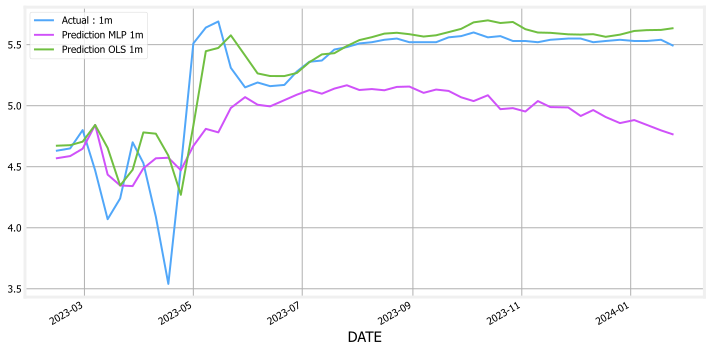

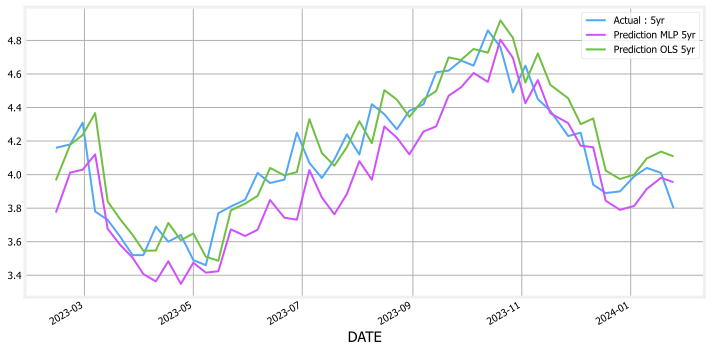

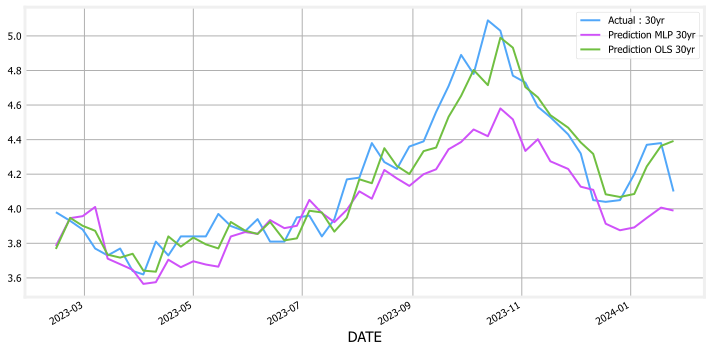

In [27]:
# comparing the different tenors (the length of time remaining before a financial contract expires) 
# we wanted to predict
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10, 5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10, 5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10, 5));